# Auto production
- Carlo Dieltjens - Raf Mesotten - Yannick Pottiez
- April 2024

## Overview
We are looking at the cars.csv dataset, it contains information about sales of 2nd hand Volvo cars. We have some questions about this, answer these questions by writing a bit of code and writing down the answers in a Jupyter Notebook.

In [1]:
# Importeer libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
from scipy.stats import norm
import json

In [2]:
# Import dataset
df_cars = pd.read_csv(os.path.join('..', 'data', 'input', 'cars.csv'))

In [3]:
# Import functions
sys.path.append('../scripts')  # definieer path with scripts
from fuel_mappings import fuel_mapping
from make_a_chart import horizontal_bar_chart
from make_a_chart import generate_plot_ecdf

In [4]:
# Import json-file with graphic colours
with open('../scripts/colours.json', 'r') as json_bestand:
    colours = json.load(json_bestand)

## Exploration of dataframe

In [5]:
# Print all columns
print(df_cars.columns)

Index(['manufacturer', 'model', 'year', 'mileage', 'engine', 'transmission',
       'drivetrain', 'fuel_type', 'mpg', 'exterior_color', 'interior_color',
       'accidents_or_damage', 'one_owner', 'personal_use_only', 'seller_name',
       'seller_rating', 'driver_rating', 'driver_reviews_num', 'price_drop',
       'price'],
      dtype='object')


#### Find and delete duplicate rows

In [6]:
# Count of rows before deduplication
print('Count of cars before deduplication:', len(df_cars))

df_cars['duplicate'] = df_cars.duplicated(keep='first') # find duplicates in new column
df_cars = df_cars[df_cars['duplicate'] == False]
print('Count of cars after deduplication:', len(df_cars))
df_cars = df_cars.drop('duplicate', axis=1) # delete newly made duplicate column

Count of cars before deduplication: 762091
Count of cars after deduplication: 752946


#### Relevant columns with categorical variables

In [7]:
# Columns with datatype 'object' (categorical variables)
object_columns = df_cars.select_dtypes(include=['object']).columns.tolist()

# Make list to save dictionaries with column names with unique values
unique_values_list = []

# Calculate count of unique values for each column
for column in object_columns:
    unique_values = df_cars[column].nunique()
    unique_values_list.append({'Column': column, 'Unique Values': unique_values})

# Convert dictionary list to a dataframe
unique_values_df = pd.DataFrame(unique_values_list)
print(unique_values_df)

           Column  Unique Values
0    manufacturer             30
1           model          12187
2          engine           6903
3    transmission           1313
4      drivetrain             33
5       fuel_type             36
6             mpg            865
7  exterior_color           7681
8  interior_color           4679
9     seller_name          18254


For our analysis, the following non-numeric columns are redundant: model, engine, transmission, drivetrain, exterior_color, interior_color. We store it as a new data frame: df_cars_relevant_cols.

In [8]:
# Delete columns with datatype 'object' not relevant for analysis
df_cars_relevant_cols = df_cars.drop(columns=['model',
                                         'engine',
                                         'transmission',
                                         'drivetrain',
                                         'mpg',
                                         'exterior_color',
                                         'interior_color',
                                         'seller_name'],
                                errors='ignore')

#### Relevant columns with numeric variables

In [9]:
# Summary statistics for numeric columns
summary_stats = df_cars.describe()

# Delete columns with data type 'object'
numerical_df = df_cars.select_dtypes(exclude=['object'])

# Get data types of each column (without object columns)
data_types_row = pd.DataFrame(numerical_df.dtypes, columns=['data_type']).T

# Combine data types and summary stats
combined_summary = pd.concat([data_types_row, summary_stats], axis=0)

# Transpose and print combined summary
print(combined_summary.T)

                    data_type     count          mean             std     min  \
year                    int64  752946.0   2017.790013        5.114479  1915.0   
mileage               float64  752468.0  55791.034956     43541.11593     0.0   
accidents_or_damage   float64  729288.0      0.228017        0.419554     0.0   
one_owner             float64  722176.0      0.562032        0.496137     0.0   
personal_use_only     float64  728652.0      0.657201        0.474645     0.0   
seller_rating         float64  541438.0       4.15933        0.804872     1.0   
driver_rating         float64  721666.0       4.62359        0.276817     1.0   
driver_reviews_num    float64  752946.0     89.692752      115.374787     0.0   
price_drop            float64  406236.0   1007.430934     1374.759058   100.0   
price                 float64  752946.0  35208.991345  1629960.178736     1.0   

                         25%      50%      75%           max  
year                  2016.0   2019.0   2021.

For this analysis, the following columns are obsolete: one_owner, personal_use_only, driver_rating, driver_reviews_num, price_drop. Hence, thes columns will be deleted from df_cars_cleaned.

In [10]:
# Delete columns not relevant for analysis (with data type not equal to 'object').
df_cars_relevant_cols = df_cars_relevant_cols.drop(columns=['one_owner',
                                                  'personal_use_only',
                                                  'seller_rating',
                                                  'driver_rating', 
                                                  'driver_reviews_num', 
                                                  'price_drop'],
                                         errors='ignore')

This results in a dataframe that only holds columns relevant for the analysis.

In [11]:
print(df_cars_relevant_cols.columns)

Index(['manufacturer', 'year', 'mileage', 'fuel_type', 'accidents_or_damage',
       'price'],
      dtype='object')


#### Relevant rows NaN values
Calculation below gives an insight in count and share of NaN values for each column.

In [12]:
# Count NaN values for each column in df_cars_relevant
na_counts = df_cars_relevant_cols.isna().sum()

# Count of rows in DataFrame
total_rows = len(df_cars_relevant_cols)

# Count of non NaN values for each column
non_na_counts = total_rows - na_counts

# Percentage NaN values per column
na_percentage = (na_counts / total_rows * 100).round(1)

# Make DataFrame with NaN values, non NaN values and percentages
output_df = pd.DataFrame({
    '# NaN values': na_counts,
    '% NaN values': na_percentage.astype(str) + '%',
    '# non NaN values': non_na_counts
})

print(output_df)

                     # NaN values % NaN values  # non NaN values
manufacturer                    0         0.0%            752946
year                            0         0.0%            752946
mileage                       478         0.1%            752468
fuel_type                   22153         2.9%            730793
accidents_or_damage         23658         3.1%            729288
price                           0         0.0%            752946


Three of our relevant columns contain a small proportion of NaN values. We create a new data frame 'df_cars_relevant_rows_and_cols' in which we transform all data from 'df_cars_relevant_cols' into more usable data. In it, records with NaN values have been removed.

In [13]:
# Make copy of df_cars_relevant_cols
df_cars_relevant_rows_and_cols = df_cars_relevant_cols.copy()

# Delete NaN values from new DataFrame
df_cars_relevant_rows_and_cols.dropna(subset=['year', 'mileage', 'price'], inplace=True)

## Data cleaning

#### Data cleaning of  categorical variables
Let's look at the different values of the remaining categorical variables to determine whether any errors, inconsistencies,... can be seen.

In [14]:
# Print list of all values of manufacturers
manufacturers = df_cars_relevant_rows_and_cols['manufacturer'].unique()
print(manufacturers)

['Acura' 'Audi' 'BMW' 'Buick' 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge'
 'Ford' 'GMC' 'Honda' 'Hyundai' 'INFINITI' 'Jaguar' 'Jeep' 'Kia'
 'Land Rover' 'Lexus' 'Lincoln' 'Mazda' 'Mercedes-Benz' 'Mitsubishi'
 'Nissan' 'Porsche' 'RAM' 'Subaru' 'Tesla' 'Toyota' 'Volkswagen' 'Volvo']


In [15]:
# Total count of records in DataFrame
total_record_count = len(df_cars_relevant_rows_and_cols)

# Percentual share of records where accidents_or_damage equals to 0 and 1
aandeel_0 = (df_cars_relevant_rows_and_cols['accidents_or_damage'] == 0).sum() / total_record_count * 100
aandeel_1 = (df_cars_relevant_rows_and_cols['accidents_or_damage'] == 1).sum() / total_record_count * 100

print()  # Print blank line
print("Share accidents_or_damage=0: {:.2f}%".format(aandeel_0))
print("Share accidents_or_damage=1: {:.2f}%".format(aandeel_1))


Share accidents_or_damage=0: 74.77%
Share accidents_or_damage=1: 22.09%


The list of manufacturers and the records with accidents_or_damage is valuable. But the one for fuel_types could use some data cleansing, as you can see below:

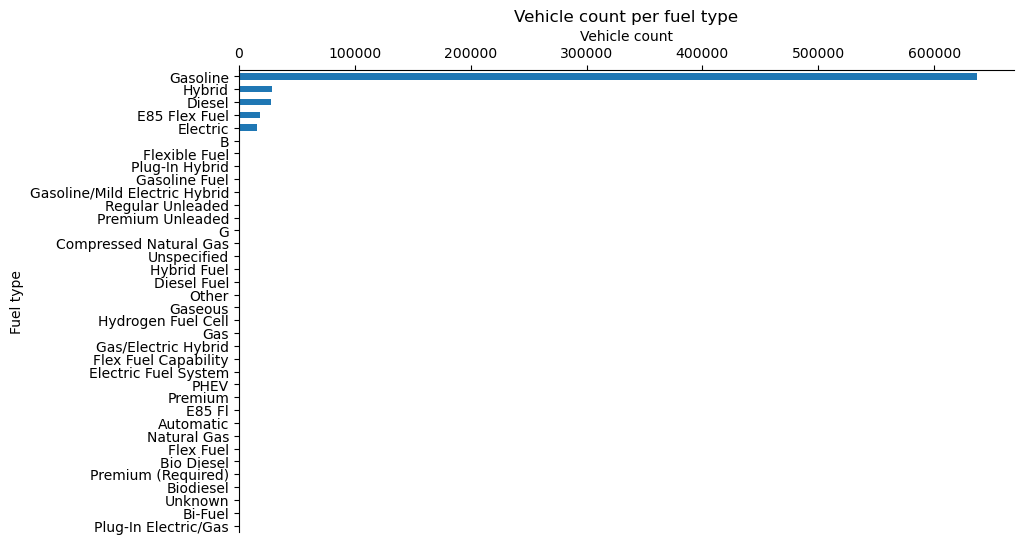

In [16]:
# We create a horizontal bar chart for all fuel_types, to check occurence of each fuel_type
values_fuel_type = df_cars_relevant_rows_and_cols['fuel_type'].value_counts(ascending=True)
horizontal_bar_chart(values_fuel_type, 
                     'Vehicle count per fuel type',
                     'Vehicle count',
                     'Fuel type')

These are far too many types. We reduce the number of categories using a mapping:

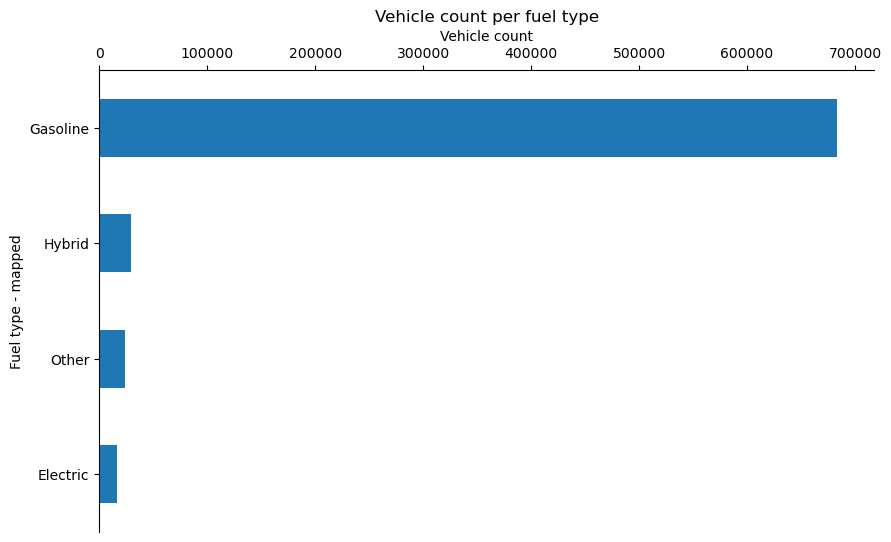

In [17]:
# Map 'fuel_type' kolom in df_cars with fuel mapping dictionary
df_cars_relevant_rows_and_cols['fuel_type_mapped'] = df_cars_relevant_rows_and_cols['fuel_type'].map(fuel_mapping)

# We create a horizontal bar chart for all fuel_types
values_mapped_fuel_type = df_cars_relevant_rows_and_cols['fuel_type_mapped'].value_counts(ascending=True)
horizontal_bar_chart(values_mapped_fuel_type,
                     'Vehicle count per fuel type',
                     'Vehicle count',
                     'Fuel type - mapped')

In [18]:
# Delete rows where 'fuel_type_mapped' equals to 'Other' and make a copy.
# This is a relatively small share.
df_cars_cleaned = df_cars_relevant_rows_and_cols[df_cars_relevant_rows_and_cols['fuel_type_mapped'] != 'Other'].copy()

# Assign values of 'fuel_type_mapped' to 'fuel_type' in df_cars_cleaned
df_cars_cleaned['fuel_type'] = df_cars_cleaned['fuel_type_mapped']

# Delete 'fuel_type_mapped' column
df_cars_cleaned.drop(columns=['fuel_type_mapped'], inplace=True)

#### Data cleaning of numeric variables¶
Let's look at the different values of the remaining numeric columns to determine whether any errors, inconsistencies,... can be seen. What does the distribution of our numeric variables look like?

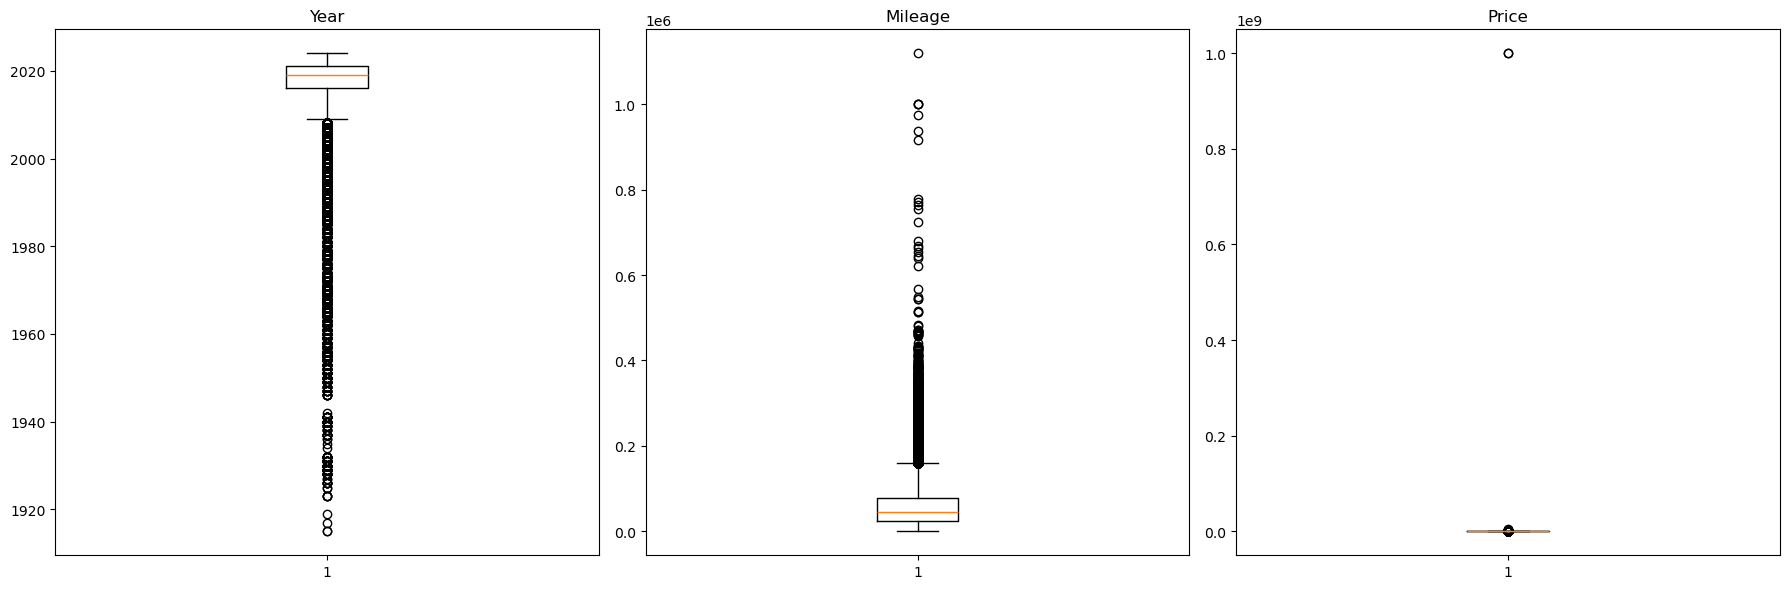

In [19]:
# Select necessary variables for boxplots
year_data = df_cars_relevant_rows_and_cols['year']
mileage_data = df_cars_relevant_rows_and_cols['mileage']
price_data = df_cars_relevant_rows_and_cols['price']

# Make a figure with three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot 'year'
axs[0].boxplot(year_data)
axs[0].set_title('Year')

# Boxplot 'mileage'
axs[1].boxplot(mileage_data)
axs[1].set_title('Mileage')

# Boxplot 'price'
axs[2].boxplot(price_data)
axs[2].set_title('Price')

plt.tight_layout()
plt.show()

In [20]:
# Show highest price values
print('Top 30 price:')

print(df_cars_relevant_rows_and_cols['price']
      .astype(int)
      .sort_values(ascending=False)
      .head(30)
     )

print()  # Blank line

# Show highest values for 'mileage'
print('Top 10 mileage:')

print(df_cars_relevant_rows_and_cols['mileage']
      .astype(int)
      .sort_values(ascending=False)
      .head(10)
     )

Top 30 price:
188113    1000000000
108142    1000000000
84358        4999999
636956       3490000
613085       2250000
609009       2099995
613080       1899999
49078        1750000
613084       1650000
213659       1575000
613079       1549991
613081       1499177
613083       1495000
613082       1400000
613086       1390000
616430       1350000
213649       1295000
213658       1275000
213641       1269000
615573       1200888
528281       1199990
213647       1190000
540908       1150000
213644       1149900
244466       1111111
91190        1111111
615422        899975
613087        849900
616478        795000
616115        789900
Name: price, dtype: int32

Top 10 mileage:
756847    1119067
511961     999999
76422      999999
494409     999999
617503     974302
319941     938032
522994     915383
136180     777698
669643     769938
229883     763474
Name: mileage, dtype: int32


The variable **year** looks solid. As expected, most 2nd hand cars are from recent years. There are many outliers at the lower end (vintage cars), but that is not an issue.
The variable **mileage** looks as expected: The vast majority of vehicles have driven less than 200 000 miles. And there are some outliers at the top end. There three cars with mileage of exactly 999,999. These might include vehicles whose odometer contains only 6 digits. We decide to keep all records and not filter out any outliers.
The variable **price** contained very extreme outliers (including 3x 1 billion). After visual analysis inspection of the boxplot of the original dataset, we set the limit at 1 million. As a result, we remove the highest 27 values for further analysis (=0.0035% of all data points). This way, we extract more value from our visualisations, and our visualisations are not skewed by a few extreme values.

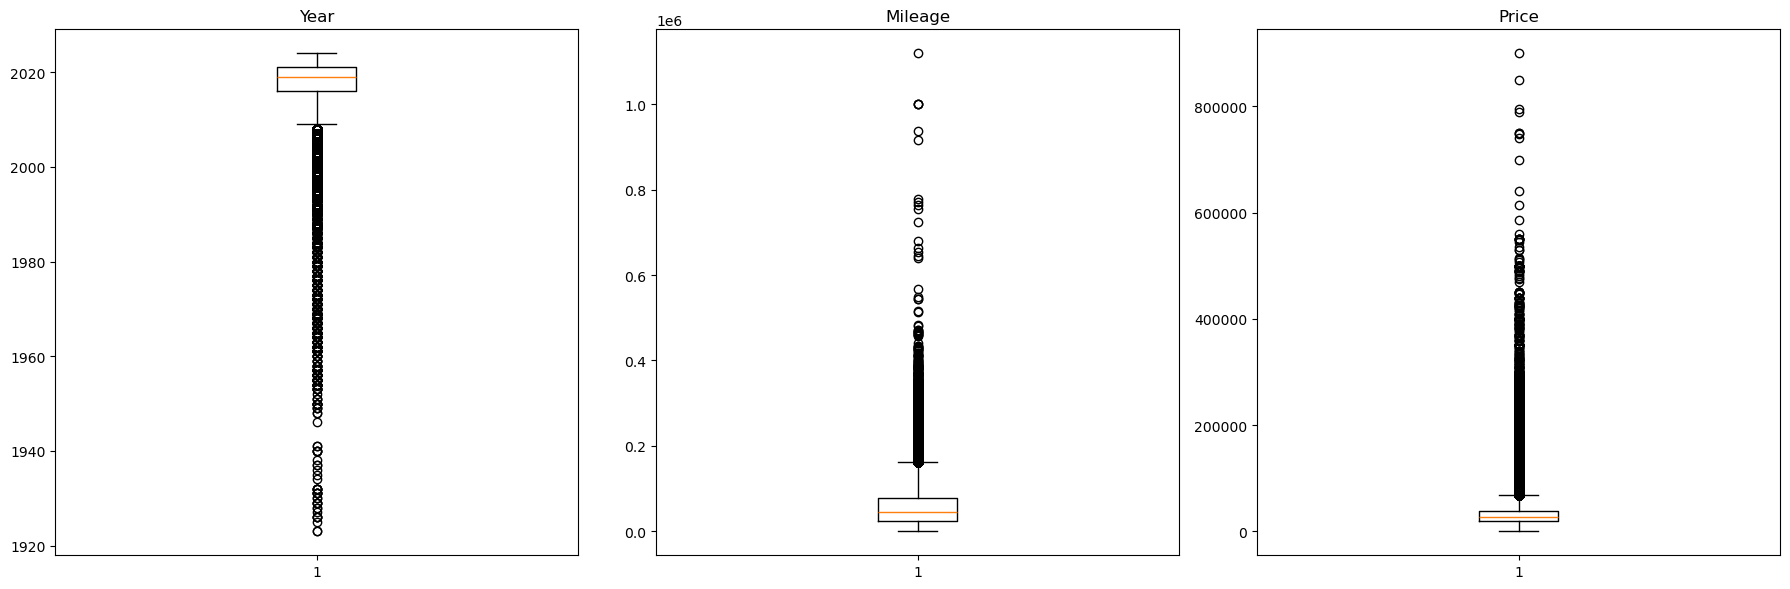

In [21]:
# Filter out price outliers. These are not withdrawn for the rest of the analysis (see below).
df_cars_cleaned = df_cars_cleaned[df_cars_cleaned['price'] <= 1000000]

# Select necessary variables for boxplots
year_data = df_cars_cleaned['year']
mileage_data = df_cars_cleaned['mileage']
price_data = df_cars_cleaned['price']

# Make figure with three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot 'year'
axs[0].boxplot(year_data)
axs[0].set_title('Year')

# Boxplot 'mileage'
axs[1].boxplot(mileage_data)
axs[1].set_title('Mileage')

# Boxplot 'price'
axs[2].boxplot(price_data)
axs[2].set_title('Price')

plt.tight_layout()
plt.show()

### Vraag 1:
Wat voor soort data zijn year, fuel_type en seller_rating? Motiveer je antwoord.

Answer: When exploring the data (see previous chapter), we already came to the following conclusions:

**year**: numeric (more specifically: integer)

**fuel_type**: categorical (more specifically: non-ordinate, there is no ranking between these categories)

**seller_rating**: can be interpreted both numerically (more specifically: float, incl. potential NaNs) and categorically (more specifically: ordinal), this depends on the business question.

### Vraag 2:
Ik vraag me af hoe een gewoonlijke (mbt prijs) $2^e$ hands Volvo eruit ziet. Kan je deze zoeken en tonen?

Answer: despite the fact that we have already filtered out some extreme outliers in terms of price, our data frame still contains a lot of extreme values. The median is therefore the safest centre measure. For Question 3, we also look at other centre measures.

In [22]:
# Make DataFrame with only Volvo's
df_cars_volvo = df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']

# Calculate median price for all Volvo's, and also for (un)damaged Volvo's
median_price_volvo = df_cars_volvo['price'].median()
median_price_volvo_accidents = df_cars_volvo[df_cars_volvo['accidents_or_damage'] == 1]['price'].median()
median_price_volvo_no_accidents = df_cars_volvo[df_cars_volvo['accidents_or_damage'] == 0]['price'].median()
                  
print(f"Median price 2nd hand Volvo: {round(median_price_volvo)}")
print(f"Median price 2nd hand Volvo with damage or accident: {round(median_price_volvo_accidents)}")
print(f"Median price 2nd hand Volvo without damage or accident: {round(median_price_volvo_no_accidents)}")

Median price 2nd hand Volvo: 36590
Median price 2nd hand Volvo with damage or accident: 28501
Median price 2nd hand Volvo without damage or accident: 37999


As expected, the median price of a Volvo with damage or accidents is a lot lower than the median price of a 2nd hand Volvo with no damage or accidents. Below we show some data from such a typical 'median' Volvo.

In [23]:
# Use conditional selection to directly find the row closest to the median price
volvo_median_price = df_cars_volvo.loc[(df_cars_volvo['price'] - median_price_volvo).abs().idxmin()]
volvo_median_price

manufacturer              Volvo
year                       2021
mileage                 12420.0
fuel_type              Gasoline
accidents_or_damage         0.0
price                   36590.0
Name: 756196, dtype: object

### Vraag 3:
We kunnen de verdeling van de prijs van $2^e$ hands Volvo's voorstellen met een histogram:
 - Waar zou je verwachten dat het gemiddelde +/- ligt voor deze verdeling?
 - Waar zou je verwachten dat de mediaan +/- ligt?

Teken dit histogram met `.hist` en gebruik `.axvline` om de mediaan en het gemiddelde toe te voegen aan de plot. Komt dit overeen met je verwachting?

 - Kan je de emprisiche cumulatieve distributie functie tekenen voor de verdeling die overeenkomt met dit histogram (zie ook `scipy.stats.ecdf`).

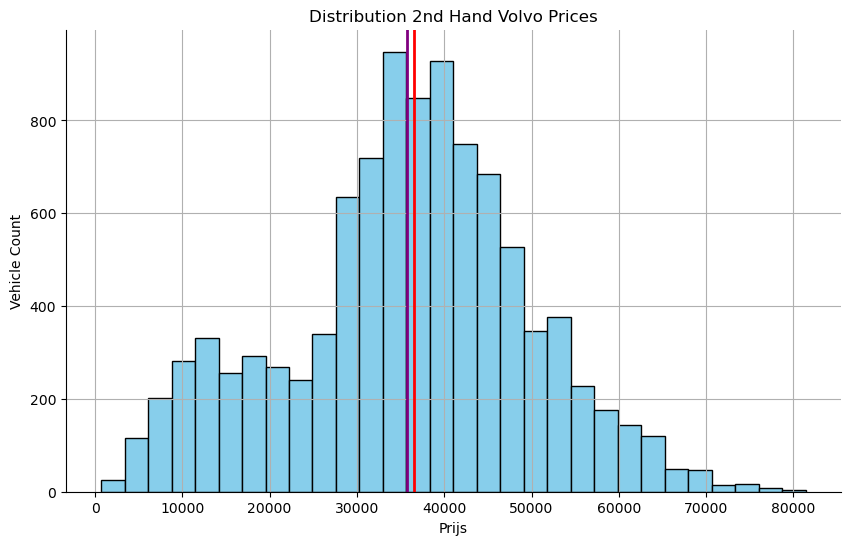

In [24]:
# Calculate average price of a 2nd hand Volvo
avg_price_volvo = (df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']
                   ['price'].mean()
                  )

# Make a histogram of 2nd hand Volvo prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']['price'], 
        bins=30, 
        color='skyblue', 
        edgecolor='black')
ax.set_title("Distribution 2nd Hand Volvo Prices")
ax.set_xlabel('Prijs')
ax.set_ylabel("Vehicle Count")

# Add vertical lines for median (red) and average (purple)
ax.axvline(median_price_volvo, 
           color='red', 
           linestyle='solid', 
           linewidth=2, 
           label='Mediaan')
ax.axvline(avg_price_volvo, 
           color='purple', 
           linestyle='solid', 
           linewidth=2, 
           label='Gemiddelde')

# Delete lines on top and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(True)
plt.show()

From the graph, we infer that the price distribution is more or less symmetrical, albeit with a slightly heavier left side. The left side will make that the mean will be lower than the median, and this is also confirmed by the calculations.

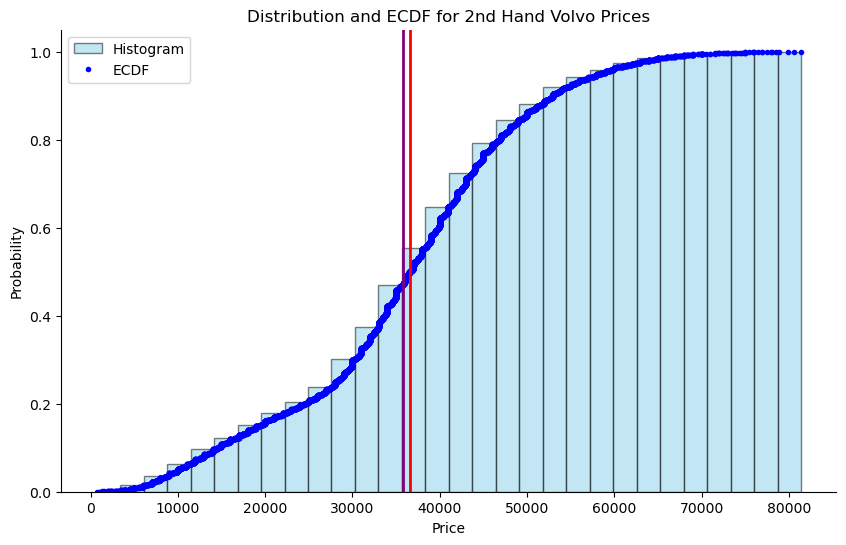

In [25]:
# Data Volvo prices
volvo_prices = df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']['price']

# Plot ECDF with vertical lines for median (red) and average (purple)
generate_plot_ecdf(volvo_prices,
                   median_price_volvo,
                   avg_price_volvo,
                   title="Distribution and ECDF for 2nd Hand Volvo Prices",
                   xlabel="Price",
                   ylabel="Probability",
                   bins=30)

As it should be, the median is at the level of a 50% probability: 50% of 2nd hand Volvo prices are above the median, and 50% of 2nd hand Volvo prices are below the median.

### Vraag 4:
Ik wil nu de verschillende fuel types vergelijken hoeveel deze kosten. Hiervoor maak ik volgende afbeelding met meerdere histogrammen hoe kunnen we deze beter maken? Welke alternatieven zijn er nog?

Answer: There are many more 2nd hand Volvo cars with Gasoline than with other fuels. A comparison obv histograms (with absolute numbers) is therefore difficult to make. The scaling on the y-axis is very different because there are many more vehicles in the database with Gasoline as fuel than there are vehicles with other fuels.

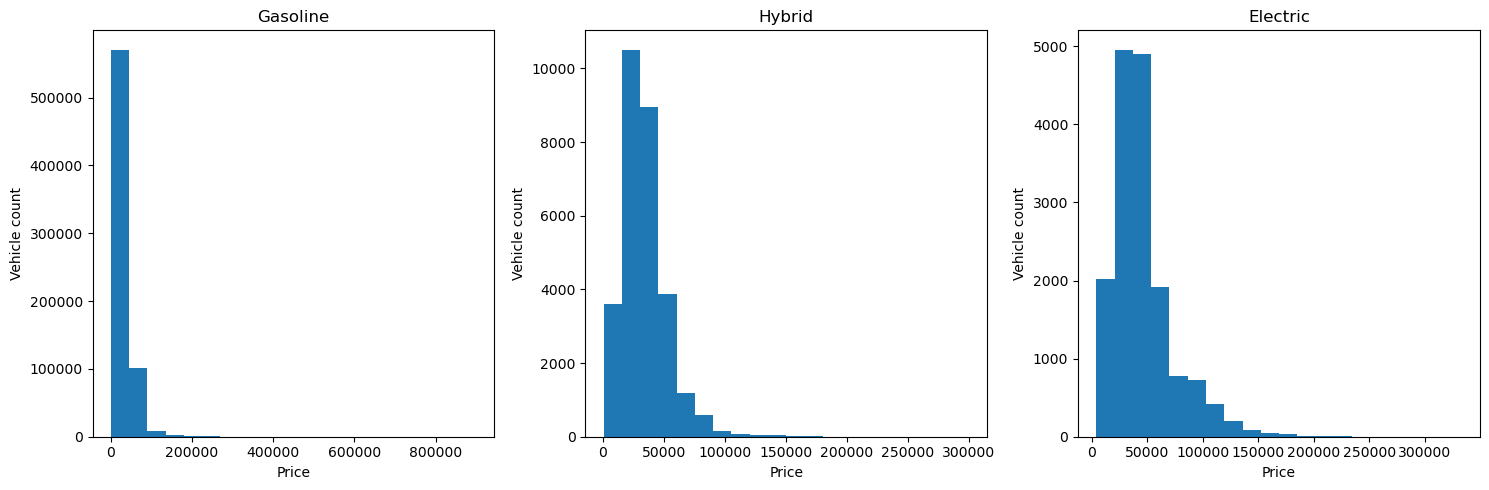

In [26]:
# Unique fuel types
fuel_types = df_cars_cleaned['fuel_type'].unique()

# Make subplots
fig, axes = plt.subplots(1, 
                         len(fuel_types), 
                         figsize=(15, 5), 
                         squeeze=False)
axes = axes.flatten()

# Number of bins
num_bins = 20  # Increase this number to increase the number of bins

# Plot histogram for each fuel type
for i, fuel_type in enumerate(fuel_types):
    ax = axes[i]
    df_cars_cleaned[df_cars_cleaned['fuel_type'] == fuel_type]['price'].plot(kind='hist', 
                                                                                 ax=ax, 
                                                                                 bins=num_bins)
    ax.set_title(fuel_type)
    ax.set_xlabel('Price')
    ax.set_ylabel("Vehicle count")

# Change layout
plt.tight_layout()

# Show plot
plt.show()

A density plot is a better way to compare these 3 categories because in a density plot, the area under each curve is always equal to 1.

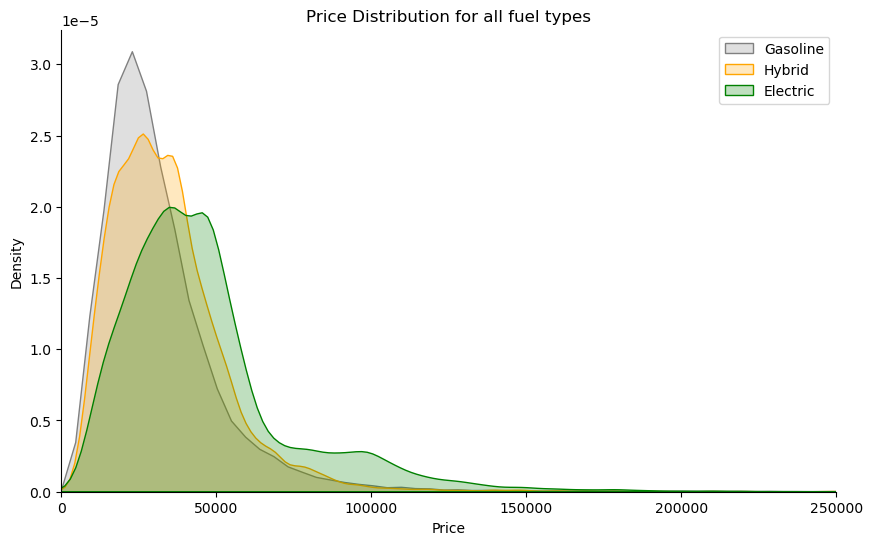

In [27]:
# Plot KDE of price distribution of all fuel types
plt.figure(figsize=(10, 6))
for fuel_type, color in colours.items():
    fuel_data = df_cars_cleaned[df_cars_cleaned['fuel_type'] == fuel_type]
    sns.kdeplot(fuel_data['price'], 
                label=fuel_type, 
                fill=True, 
                color=colours[fuel_type])

plt.title('Price Distribution for all fuel types')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.xlim(left=0)  # Lower bound x axis
plt.xlim(right=250000)  # Upper bound x axis

# Delete right and top lines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

Another way to compare density is violin plots. By comparing violin plots side by side, behaviour in the tail can be better compared, among other things.

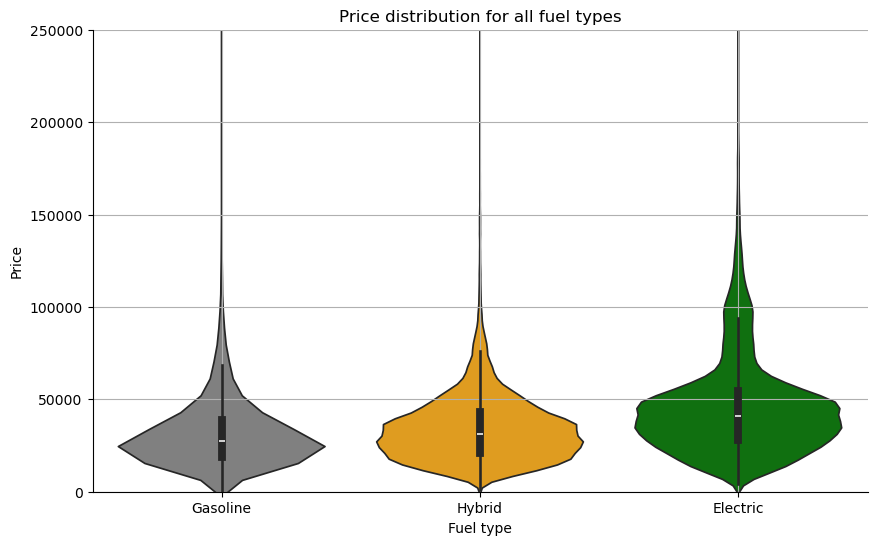

In [28]:
# Make violin plot of price distribution for all fuel types
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_cars_cleaned, 
               x='fuel_type', 
               y='price', 
               hue='fuel_type', 
               legend=False, 
               palette=colours
              )

plt.title('Price distribution for all fuel types')
plt.xlabel('Fuel type')
plt.ylabel('Price')
plt.ylim(0, 250000) # Upper bound of y axis to make plot less flat
plt.grid(True)

# Delete right and top lines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

Based on the chart above, we can say that 2nd hand cars with Gasoline are on average cheaper than electric cars.

In [29]:
# Empty dictionary to save medians
fuel_type_medians = {}

# Calculate median for each fuel type
for fuel_type in fuel_types:
    median_price = df_cars_cleaned[df_cars_cleaned['fuel_type'] == fuel_type]['price'].median()
    fuel_type_medians[fuel_type] = median_price

# Print median per fuel type
for fuel_type, median_price in fuel_type_medians.items():
    print(f"Median price for {fuel_type}: {median_price}")

Median price for Gasoline: 27441.0
Median price for Hybrid: 31397.0
Median price for Electric: 40848.0


### Vraag 5:
Gegeven volgende boxplots van de prijs van elektrische & benzine wagens, zijn volgende uitspraken waar/onwaar/niet te besluiten & leg uit:

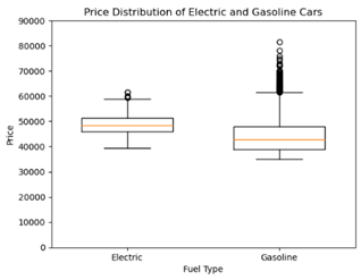

 - De spreiding op de prijs van elektrische wagens is groter dan die van benzinewagens.

 - Een wagen die meer dan 50 000 euro kost heeft een grotere kans om elektrisch te zijn dan benzine.

 - Een elektrische wagen heeft een grotere kans om meer dan 50 000 euro te kosten dan een benzine wagen.

Answer:
- **False**: Both the distance min-max and the interquartile distance are larger in petrol cars than in electric cars. Moreover, petrol cars also have more outliers.
- **Not to conclude**: Boxplots provide no information on the number of electric cars compared to the number of petrol cars. If there were equal numbers of both, the claim would be true. But if there were far fewer electric cars than petrol cars, the claim is not true.
- **True**: For petrol cars, 75% percentile is about €50 000. For electric cars, median is just below €50 000, meaning that just under half of the cars cost more. For petrol, the 75% percentile is around 50 000, meaning that the proportion of petrol cars priced >50 000 will be lower than the proportion of electric cars priced >50 000.

### Vraag 6:
Maak een visualizatie om het verband tussen mileage & price te tonen?

Answer: A good visualisation to demonstrate the relationship between 2 numerical variables is a scatter plot.

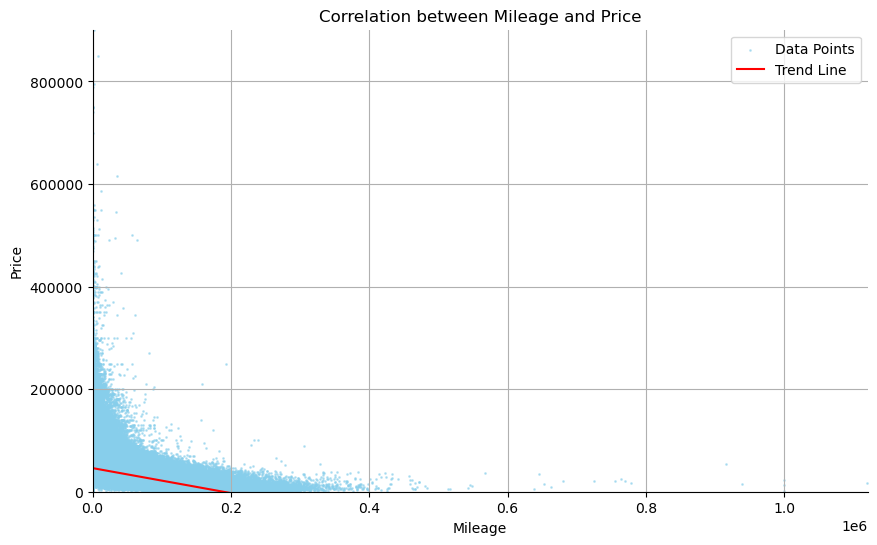

In [30]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cars_cleaned.mileage, df_cars_cleaned.price, color='skyblue', label='Data Points', s=1, alpha=0.5)

# Add labels and title
plt.title('Correlation between Mileage and Price')
plt.xlabel('Mileage')
plt.ylabel('Price')

# Add trend line
z = np.polyfit(df_cars_cleaned.mileage, df_cars_cleaned.price, 1)
p = np.poly1d(z)

# Generate a range of mileage values for the trend line
# np.linspace generates a set of numbers (in this case mileage values) that are evenly distributed over a specified range.
# np.min(df_cars_cleaned.mileage) retrieves the lowest mileage value in the dataset, and np.max(df_cars_cleaned.mileage) retrieves the highest.
# We create 100 points between these two extremes to get a smooth trend line.
mileage_range = np.linspace(np.min(df_cars_cleaned.mileage), np.max(df_cars_cleaned.mileage), 100)

# Plot the trend line
# Here we plot the trend line using 'mileage_range' as the x values and 'p(mileage_range)' as the y values.
# 'p' must be a previously defined function that models the relationship between mileage and another variable (such as price).
# We choose the colour 'red' for the trend line and label it 'Trend Line'.
plt.plot(mileage_range, p(mileage_range), color='red', label='Trend Line')

# Add limits for x and y axes based on the data range
plt.xlim(0, np.max(df_cars_cleaned.mileage) + 1000)
plt.ylim(0, np.max(df_cars_cleaned.price) + 1000)

# Delete right and top lines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add legend and show graphic
plt.legend()
plt.grid(True)
plt.show()

We see a very diffuse picture. The presumption is that the **price** (and hence the correlation between mileage and price) **depends heavily on the car make and whether there is damage to the vehicle or not**. And the chart below shows that to be the case.

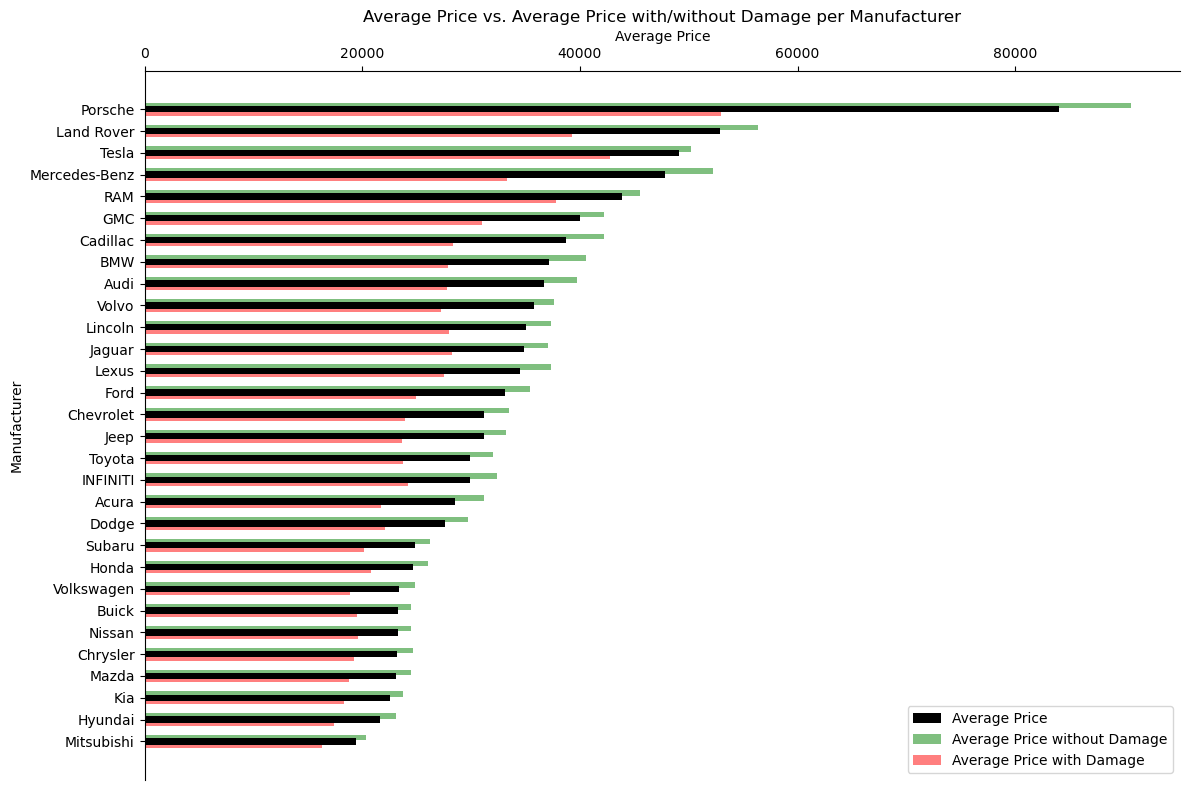

In [31]:
# Group by manufacturer and calculate average price and counts
manufacturer_stats = df_cars_cleaned.groupby('manufacturer')['price'].agg(
    Average_Price='mean',
    Count='count',
    Avg_Price_damage_1=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 1].mean(),
    Count_damage_1=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 1].count(),
    Avg_Price_damage_0=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 0].mean(),
    Count_damage_0=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 0].count()
).reset_index()

# Sort the data by the longest bar
manufacturer_stats_longest_bar = manufacturer_stats.sort_values(by=['Average_Price', 'Avg_Price_damage_1', 'Avg_Price_damage_0'], ascending=True)

# Select data to plot
manufacturers = manufacturer_stats_longest_bar['manufacturer']
avg_price = manufacturer_stats_longest_bar['Average_Price']
avg_price_damage_1 = manufacturer_stats_longest_bar['Avg_Price_damage_1']
avg_price_damage_0 = manufacturer_stats_longest_bar['Avg_Price_damage_0']

# Set the positions of the bars on the x-axis
position = np.arange(len(manufacturers))

# Set the width of the bars
bar_width = 0.25

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(position - bar_width/1.5, 
         avg_price_damage_1, 
         height=bar_width, 
         color='red', 
         label='Average Price with Damage', 
         alpha=0.5)
plt.barh(position + bar_width/1.5, 
         avg_price_damage_0, 
         height=bar_width, 
         color='green', 
         label='Average Price without Damage', 
         alpha=0.5)
plt.barh(position, 
         avg_price, 
         height=bar_width*1.2, 
         color='black', 
         label='Average Price', 
         alpha=1)

# Add labels and title
plt.xlabel('Average Price')
plt.ylabel('Manufacturer')
plt.yticks(position, manufacturers)
plt.title('Average Price vs. Average Price with/without Damage per Manufacturer')
plt.legend()

# Move x-axis to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# Reverse legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))

# Remove right and bottom spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

We can zoom in on the correlation between Price and Mileage for each brand. As expected, we see a **negative correlation** for each brand: The more miles a car was driven, the less that car is worth overall. We work with only 10% of the data in the graphics below, owv the long calculation time. We use the same scale in each graph so that we can compare them.

In all graphs (1 graph per brand) we distinguished between vehicles with damage (red) and without damage (green). The trend lines are also in the corresponding colour. For each brand, the green line (no damage) is steeper than the red trend line (does damage): A vehicle with few kilometres on the odometer is worth more if there were no damage or accidents.

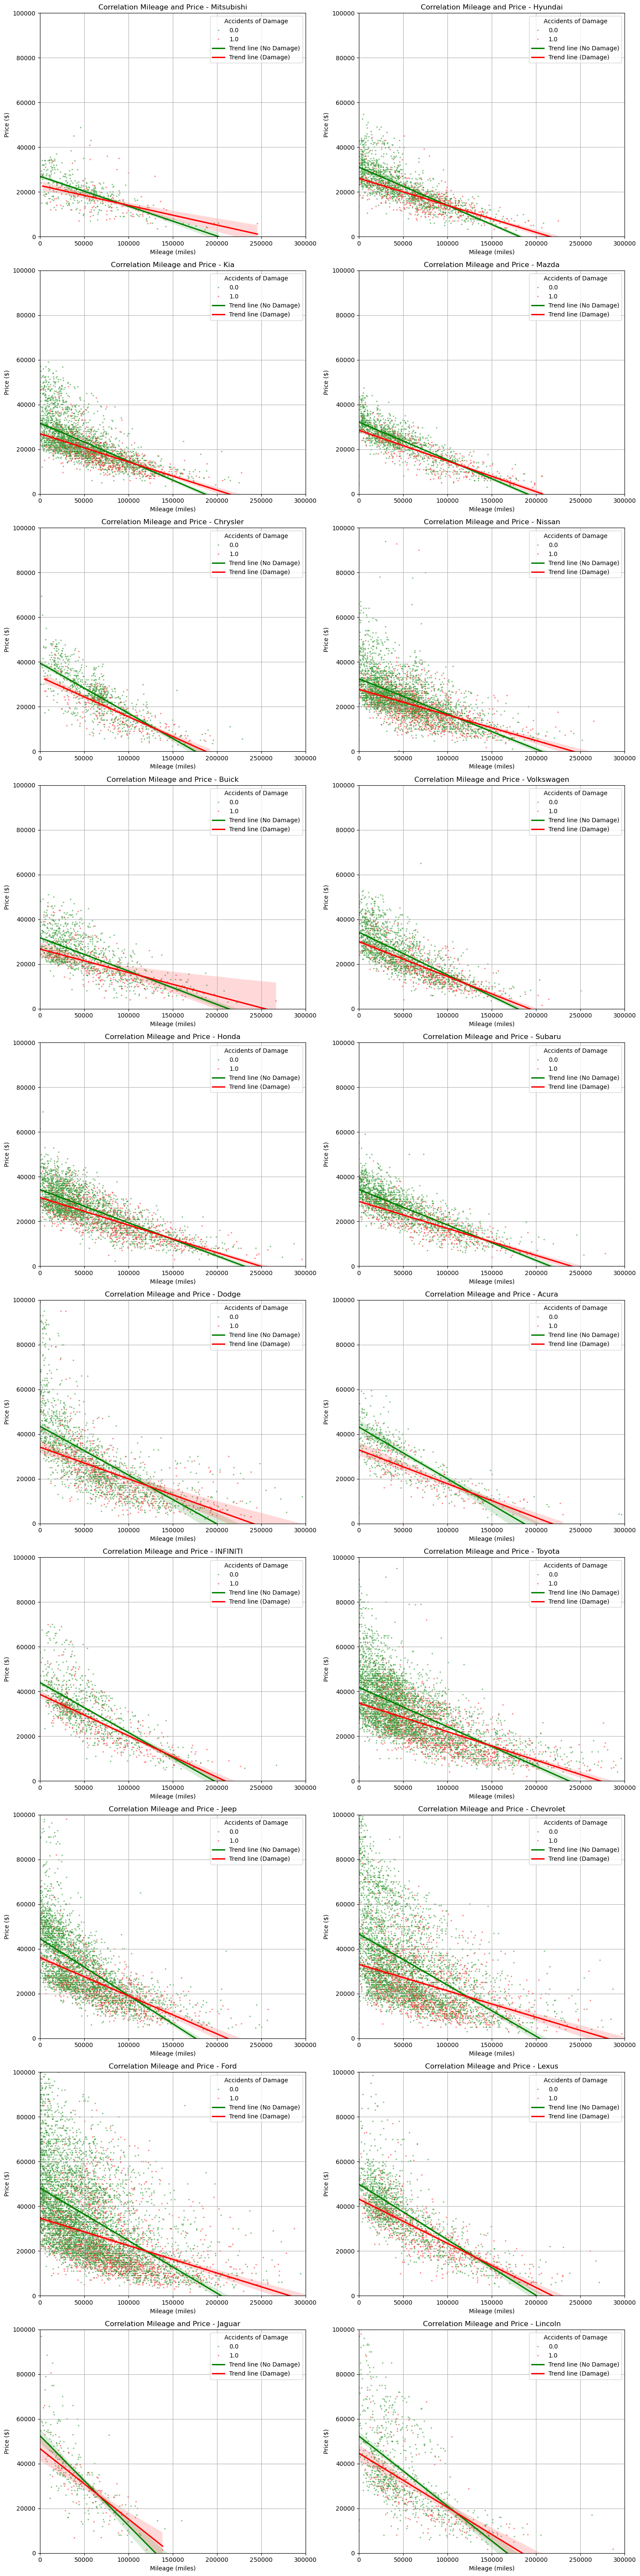

In [32]:
# Sample small share
df_cars_sample = df_cars_cleaned.sample(frac=0.1, random_state=42)

# Calculate the number of rows required for the subplot grid
num_rows = (len(manufacturers) + 2) // 3  # Round up the division result

# Definie colours for two categories
color_mapping = {1: 'red', 0: 'green'}

# Make subplots for each manufacturer
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

# Flatten axes array for iterating each subplot
axes_flat = axes.flatten()

for ax, manufacturer in zip(axes_flat, manufacturers):
    # Filter data for actual manufacturer
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    
    # Scatter plot with different colours base on column 'accidents_or_damage'
    sns.scatterplot(x='mileage', y='price', hue='accidents_or_damage', data=df_manufacturer, ax=ax, palette=color_mapping, s=6, alpha=0.5)

    # Filter data without accidents or damage
    df_no_damage = df_manufacturer[df_manufacturer['accidents_or_damage'] == 0]
    # Plot trendline data without accidents or damage (green)
    sns.regplot(x='mileage', y='price', data=df_no_damage, ax=ax, scatter=False, color='green', label='Trend line (No Damage)')
    
    # Filter data with accidents or damage
    df_damage = df_manufacturer[df_manufacturer['accidents_or_damage'] == 1]
    # Plot trendline data without accidents or damage (red)
    sns.regplot(x='mileage', y='price', data=df_damage, ax=ax, scatter=False, color='red', label='Trend line (Damage)')

    # Add labels and title
    ax.set_title(f'Correlation Mileage and Price - {manufacturer}')
    ax.set_xlabel('Mileage (miles)')
    ax.set_ylabel('Price ($)')

    # Define axes limits
    ax.set_xlim(left=0, right=300000)
    ax.set_ylim(bottom=0, top=100000)

    # Add legend
    ax.legend(title='Accidents of Damage')
    ax.grid(True)

# Delete unused subplots
for i in range(len(manufacturers), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

If we abstract for a moment from whether or not there is damage, the chart below is, in our opinion, the best possible representation to demonstrate the relationship between mileage and price: For all brands, a car becomes worth less the more kilometres (or miles) on the odometer. And some brands are a lot more expensive at purchase than others. **Note that in this and all previous graphs we worked with a linear trend line, although the actual correlation may not necessarily be linear** (e.g.: If a vehicle drives 100 miles, the drop in value may be much greater in case there are a total of 100 miles on the odometer after driving that 100 miles, than for say 100 000 miles on the odometer).

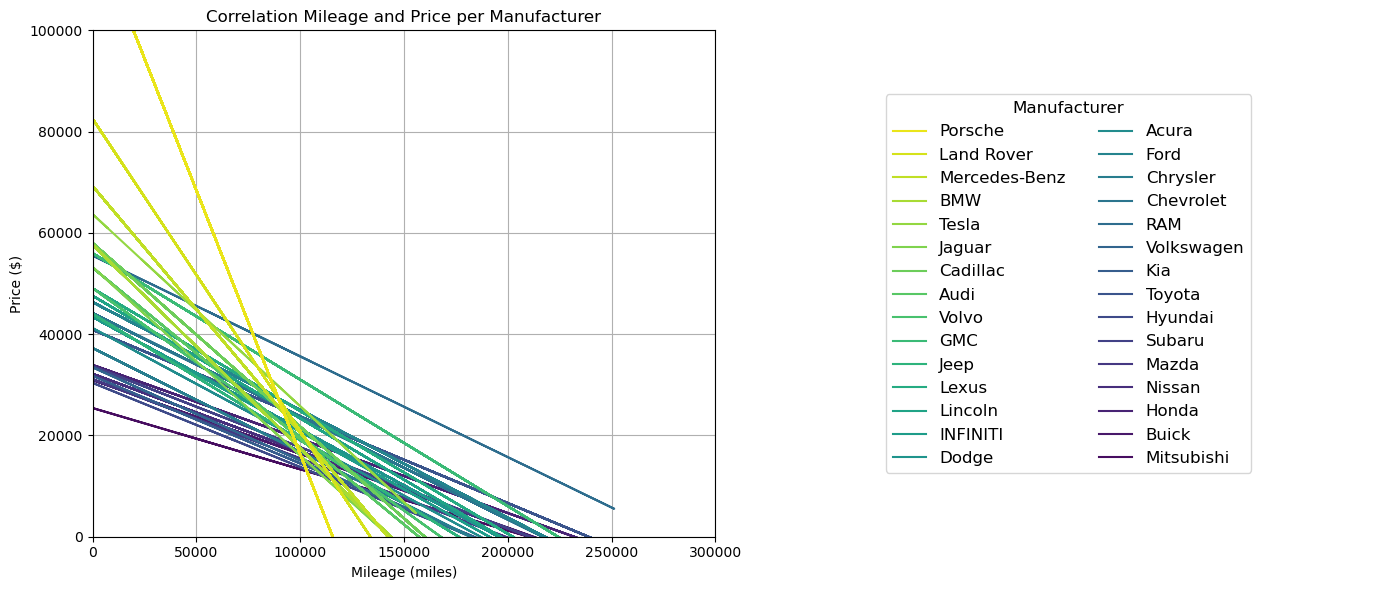

In [33]:
# Filter price and mileage outliers
df_cars_sample = df_cars.sample(frac=0.1, random_state=42)
df_cars_sample = df_cars_sample[(df_cars_sample.price < 1000000) & (df_cars_sample.mileage < 500000)]

# Get unique manufacturers
manufacturers = df_cars_sample['manufacturer'].unique()

# Calculate slope and intercept for each manufacturer
slopes = {}
intercepts = {}
for manufacturer in manufacturers:
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    X = df_manufacturer['mileage']
    y = df_manufacturer['price']
    X_mean = X.mean()
    y_mean = y.mean()
    slope = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2)
    intercept = y_mean - slope * X_mean
    slopes[manufacturer] = slope
    intercepts[manufacturer] = intercept

# Sort manufacturer by slope
sorted_manufacturers = sorted(manufacturers, key=lambda x: slopes[x], reverse=True)

# Make scatter plot for each data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Assign colours on base of range
colors = sns.color_palette('viridis', len(sorted_manufacturers))

for i, manufacturer in enumerate(sorted_manufacturers):
    # Filter data for current manufacturer
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    
    # Generate values for regression line
    X = df_manufacturer['mileage']
    regression_line = slopes[manufacturer] * X + intercepts[manufacturer]
    
    # Plot regression with label and colour
    axs[0].plot(X, regression_line, label=manufacturer, color=colors[i])

# Add labels and title for first subplot
axs[0].set_title('Correlation Mileage and Price per Manufacturer')
axs[0].set_xlabel('Mileage (miles)')
axs[0].set_ylabel('Price ($)')
axs[0].set_xlim(left=0, right=300000)
axs[0].set_ylim(bottom=0, top=100000)
axs[0].grid(True)

# Add legend for second subplot
handles, labels = axs[0].get_legend_handles_labels()
legend = axs[1].legend(reversed(handles), reversed(labels), fontsize='large', loc='center', bbox_to_anchor=(0.5, 0.5), ncol=2)
legend.set_title('Manufacturer', prop={'size': 'large'})

# Hide axes in second subplot
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Vraag 7:
Volgens deze data is de gemiddelde prijs van $2^e$ hands elektrische Volvo’s 48 000 euro; als we veronderstellen dat onze dataset representatief is voor alle 2de hands volvo’s, hoe kan je de accuraatheid van deze schatting nagaan?

Answer: A standard deviation of 4,162.03 euros means that we can expect most of the prices of the electric used Volvos to be within the distance of about 4,162.03 euros from the average of 48,788.39 euros. Based on the calculated confidence interval, we can say with 95% certainty that the true average of all electric used Volvos is somewhere between 48,275.54 euros and 49,301.24 euros.

The average price of 48,000 euros mentioned in the statement is not within this interval, so 48,000 euros cannot be considered a likely value for the true average.

In [34]:
# Filter on fuel_type 'electric'
df_cars_volvo_electric = df_cars_volvo[df_cars_volvo['fuel_type'] == 'Electric']

# Calculate average and standard deviation of prices
avg_price_volvo_electric = df_cars_volvo_electric['price'].mean()
std_price_volvo_electric = df_cars_volvo_electric['price'].std()
median_price_volvo_electric = df_cars_volvo_electric['price'].median()

print(f"Average Estimated Price of Electric 2nd Hand Volvo's: {int(avg_price_volvo_electric)} euro")
print(f"Mean Estimated Price of Electric 2nd Hand Volvo's: {int(median_price_volvo_electric)} euro")
print(f"Standard Deviation: {int(std_price_volvo_electric)} euro")

# Calculate the confidence interval with 95% confidence
z_score = norm.ppf(0.975)  # Z-score for 95% confidence
n = len(df_cars_volvo_electric)
confidence_interval = z_score * (std_price_volvo_electric / np.sqrt(n))
lower_bound = avg_price_volvo_electric - confidence_interval
upper_bound = avg_price_volvo_electric + confidence_interval

print(f"Confidence Interval (95%): ({lower_bound:.2f}, {upper_bound:.2f})")

Average Estimated Price of Electric 2nd Hand Volvo's: 48788 euro
Mean Estimated Price of Electric 2nd Hand Volvo's: 48363 euro
Standard Deviation: 4162 euro
Confidence Interval (95%): (48275.54, 49301.24)


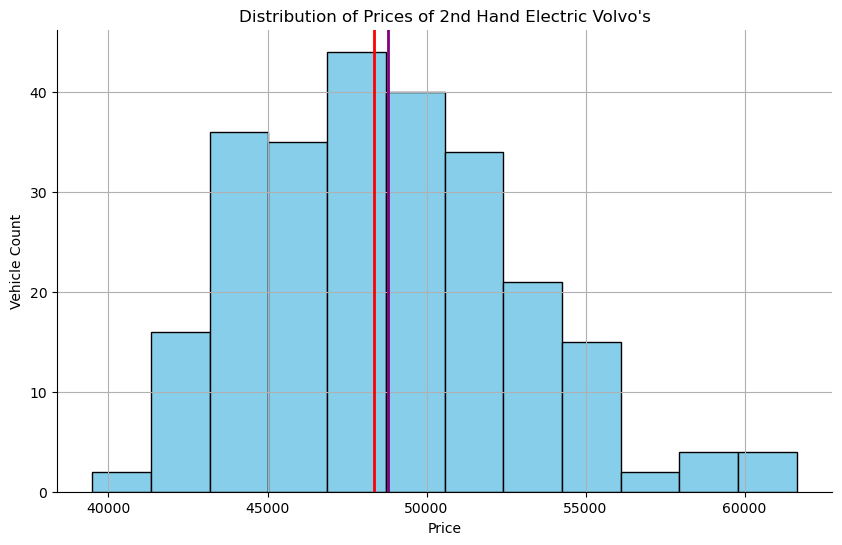

In [35]:
# Histogram of prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cars_volvo_electric['price'], bins=12, color='skyblue', edgecolor='black')
ax.set_title("Distribution of Prices of 2nd Hand Electric Volvo's")
ax.set_xlabel('Price')
ax.set_ylabel("Vehicle Count")

# Add vertical lines for median (red) and average (purple)
ax.axvline(median_price_volvo_electric, color='red', linestyle='solid', linewidth=2, label='Mediaan')
ax.axvline(avg_price_volvo_electric, color='purple', linestyle='solid', linewidth=2, label='Gemiddelde')

# Delete lines top and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(True)
plt.show()